In [1]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install PyWavelets
# !pip install -U scikit-learn
# !pip install joblib
# !pip install seaborn

In [2]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
img = cv2.imread('./dataset/cropped_images/howard/howard3.png')
img.shape

(290, 290, 3)

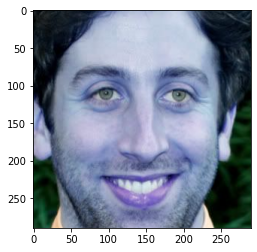

In [4]:
plt.imshow(img)

In [5]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

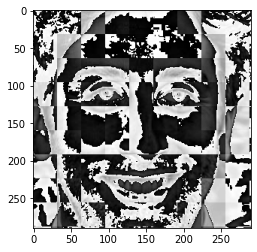

In [6]:
im_har = w2d(img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [7]:
import os 
cropped_image_dirs = []
for entry in os.scandir("./dataset/cropped_images/"):
    if entry.is_dir():
        cropped_image_dirs.append(entry.path)
cropped_image_dirs    

['./dataset/cropped_images/howard',
 './dataset/cropped_images/leonard',
 './dataset/cropped_images/raj',
 './dataset/cropped_images/sheldon']

In [8]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    print(img_dir)
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

./dataset/cropped_images/howard
./dataset/cropped_images/leonard
./dataset/cropped_images/raj
./dataset/cropped_images/sheldon


{'howard': ['./dataset/cropped_images/howard\\howard1.png',
  './dataset/cropped_images/howard\\howard11.png',
  './dataset/cropped_images/howard\\howard12.png',
  './dataset/cropped_images/howard\\howard14.png',
  './dataset/cropped_images/howard\\howard15.png',
  './dataset/cropped_images/howard\\howard18.png',
  './dataset/cropped_images/howard\\howard19.png',
  './dataset/cropped_images/howard\\howard2.png',
  './dataset/cropped_images/howard\\howard21.png',
  './dataset/cropped_images/howard\\howard22.png',
  './dataset/cropped_images/howard\\howard23.png',
  './dataset/cropped_images/howard\\howard24.png',
  './dataset/cropped_images/howard\\howard25.png',
  './dataset/cropped_images/howard\\howard26.png',
  './dataset/cropped_images/howard\\howard27.png',
  './dataset/cropped_images/howard\\howard28.png',
  './dataset/cropped_images/howard\\howard3.png',
  './dataset/cropped_images/howard\\howard30.png',
  './dataset/cropped_images/howard\\howard31.png',
  './dataset/cropped_ima

In [9]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    print(celebrity_name)
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

howard
leonard
raj
sheldon


{'howard': 0, 'leonard': 1, 'raj': 2, 'sheldon': 3}

In [30]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [31]:
len(X[0])

4096

In [32]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(176, 4096)

In [58]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8309859154929577

In [95]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        24
           1       1.00      0.17      0.29         6
           2       0.93      0.65      0.76        20
           3       0.78      1.00      0.88        21

    accuracy                           0.83        71
   macro avg       0.88      0.70      0.71        71
weighted avg       0.86      0.83      0.80        71



In [96]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [97]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [98]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.828571,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.723810,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.819048,{'logisticregression__C': 1}


In [99]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [100]:
best_estimators['svm'].score(X_test,y_test)

0.8450704225352113

In [101]:
best_estimators['random_forest'].score(X_test,y_test)

0.676056338028169

In [102]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8591549295774648

In [103]:
best_clf = best_estimators['svm']

In [104]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[24,  0,  0,  0],
       [ 0,  2,  1,  3],
       [ 5,  0, 15,  0],
       [ 0,  1,  1, 19]], dtype=int64)

Text(69.0, 0.5, 'Truth')

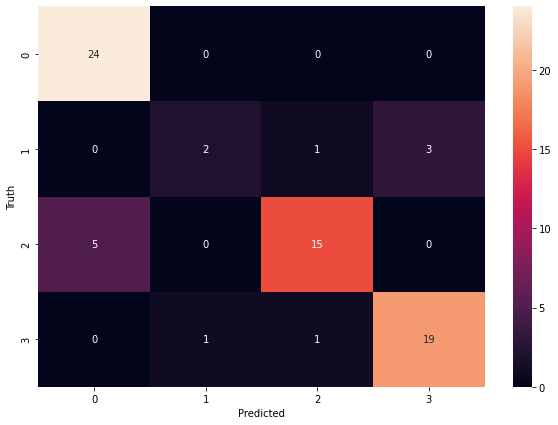

In [105]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [106]:
class_dict

{'howard': 0, 'leonard': 1, 'raj': 2, 'sheldon': 3}

In [27]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [28]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [29]:
!pip freeze > requirements.txt